In [629]:
from __future__ import print_function, division
import os
import sys
import numpy as np
import pandas as pd
import pylab as pl
import zipfile
import geopandas as gp
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from matplotlib import colors

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
% pylab inline

Populating the interactive namespace from numpy and matplotlib


Gather Business Data from Census Bureau and Postal Code data

In [630]:
# uncomment code for download 

# !for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

# !for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

# !for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


In [631]:
# uncomment code to download 2000 & 2001
# !wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
# !wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp01totals.zip

In [632]:
year_range = np.arange(94, 115, 1)

In [633]:
dfs = {}
for year in year_range: 
    # unzip, file, move file and save each dataframe in dictionary
    # uncomment the os.system line to move files if they are not yet downloaded 
    fname = 'zbp' + str(year)[-2:] + 'totals.zip'
    # os.system('mv ' + fname + ' ' + os.getenv('PUIDATA')) 
    dfname = 'df_' + str(year)[-2:]
    zf = zipfile.ZipFile(os.getenv('PUIDATA') + '/' + fname)
    dfs[dfname] = pd.read_csv(zf.open(fname.replace('.zip', '.txt')))
    dfs[dfname]['year'] = year + 1900
  

In [634]:
urlbegin = 'https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/'
file_name = 'nyc-zip-code-tabulation-areas-polygons.geojson'

os.system('curl -O ' + urlbegin + file_name)
os.system('mv ' + file_name + ' ' + os.getenv('PUIDATA'))

0

In [635]:
zc_shape = gp.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/' + file_name)

In [636]:
postalcodes = zc_shape.postalCode.unique() # collect unique NYC postal codes 

# Create a dataframe of only NYC data from all years

In [637]:
for key in dfs.keys():
    dfs[key].columns = [s.lower() for s in list(dfs[key].columns)]
    if 'zip' in dfs[key].columns:
        dfs[key]['NYC'] = [str(x) in postalcodes for x in dfs[key]['zip']]
    else:
        print(key)

In [638]:
master_df = pd.concat(dfs[key] for key in dfs.keys())

In [639]:
nyc_df = master_df[master_df.NYC > 0]

In [640]:
nyc_df.columns

Index([u'NYC', u'ap', u'ap_nf', u'city', u'cty_name', u'emp', u'emp_nf',
       u'empflag', u'est', u'name', u'qp1', u'qp1_nf', u'stabbr', u'year',
       u'zip'],
      dtype='object')

In [641]:
# trim dataframe to only include the number of established businesses, year and zip
mydata = nyc_df.drop([u'NYC', u'ap', u'ap_nf', u'city', u'cty_name', u'emp', u'emp_nf',
       u'empflag', u'name', u'qp1', u'qp1_nf', u'stabbr'], axis = 1)

In [642]:
# create a crosstabulation, filling any NA with 0 as that should indicate no value for the zip/yr combo
crosstabbed = pd.crosstab(mydata['zip'], mydata['year'], values = mydata['est'], aggfunc = 'sum')
crosstabbed.fillna(0, inplace = True)
crosstabbed.describe()

year          1994         1995         1996         1997         1998  \
count   244.000000   244.000000   244.000000   244.000000   244.000000   
mean    762.032787   777.049180   787.266393   806.557377   818.495902   
std    1147.993422  1176.002816  1178.958154  1204.028041  1215.217837   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%     143.250000   154.750000   152.500000   156.250000   155.000000   
50%     416.000000   434.000000   449.500000   457.000000   466.500000   
75%     879.250000   884.250000   892.500000   909.250000   933.250000   
max    6999.000000  7088.000000  7075.000000  7154.000000  7254.000000   

year          1999         2000         2001         2002         2003  \
count   244.000000   244.000000   244.000000   244.000000   244.000000   
mean    823.959016   838.135246   838.254098   843.516393   853.483607   
std    1213.771237  1235.365740  1240.248993  1203.978943  1204.637416   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%     151.000000   158.500000   146.750000   151.500000   140.000000   
50%     466.500000   472.500000   469.000000   484.500000   500.500000   
75%     927.250000   926.000000   934.500000   968.750000   972.500000   
max    7233.000000  7317.000000  7188.000000  7141.000000  7084.000000   

year      ...              2005         2006         2007         2008  \
count     ...        244.000000   244.000000   244.000000   244.000000   
mean      ...        873.245902   877.946721   884.118852   889.831967   
std       ...       1231.825838  1238.952651  1222.325884  1219.186219   
min       ...          0.000000     0.000000     0.000000     0.000000   
25%       ...        139.500000   146.250000   154.500000   158.250000   
50%       ...        497.000000   504.500000   522.000000   529.000000   
75%       ...       1008.250000  1011.250000  1005.500000  1024.750000   
max       ...       7312.000000  7415.000000  7549.000000  7472.000000   

year          2009         2010         2011         2012         2013  \
count   244.000000   244.000000   244.000000   244.000000   244.000000   
mean    894.311475   907.856557   919.315574   935.676230   953.233607   
std    1203.593287  1205.257212  1210.141261  1222.256285  1234.018051   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%     166.250000   155.250000   154.750000   141.000000   143.000000   
50%     537.500000   569.000000   561.500000   587.500000   604.000000   
75%    1039.000000  1065.000000  1097.500000  1113.500000  1185.000000   
max    7305.000000  7241.000000  7227.000000  7235.000000  7273.000000   

year          2014  
count   244.000000  
mean    967.483607  
std    1243.878583  
min       0.000000  
25%     148.750000  
50%     619.000000  
75%    1209.250000  
max    7369.000000  

[8 rows x 21 columns]

In [643]:
def normalize(series):
    '''takes series, returns normalized values
    '''
    return (series - series.mean()) / series.std()
    
for i in range(len(crosstabbed)):
    crosstabbed.iloc[i] = normalize(crosstabbed.iloc[i])
    

# Cluster Normalized Data

In [644]:
def cluster_plot(df, n_clust, cluster_algorithm = 'KMeans'):
    '''clusters dataframe according to kmeans and plots
    keyword arguments: 
    df = dataframe
    n_clust = number of clusters
    cluster algorithm: picks clustering algorithm with default of kmeans, 
    other option is AggClust for AgglomerativeClustering
    '''
    if cluster_algorithm == 'KMeans':
        clusters = KMeans(n_clust, random_state = 21).fit(df)
        cluster_labels = clusters.labels_ 
        cluster_centers = clusters.cluster_centers_
        name = 'KMeans'
        
    elif cluster_algorithm == 'AggClust':
        clusters = AgglomerativeClustering(n_clust).fit(df)
        cluster_labels = AgglomerativeClustering(n_clust).fit_predict(df) 
        name = 'Agglomerative Clustering'
        cluster_centers = []
        for i in range(n_clust): 
            cluster_centers.append(df[cluster_labels == i].mean(axis = 0))
        cluster_centers = np.array(cluster_centers)

    
    else: 
        print ('not an algorithm type')
        
    
    ncol = int(round(n_clust / 2.0))
    fig, axs = pl.subplots(ncol, 2, figsize=(20,10))
    axs = axs.ravel()

    fig.subplots_adjust(hspace = .2, wspace=.2)

    fig.text(0.5, 0.04, 'Year', ha='center', fontsize = 20)
    fig.text(0.04, 0.5, 'Established Businesses per Year (Normalized)', 
             va='center', rotation='vertical', fontsize = 20)

    pl.suptitle('{0} Clusters of Established Businesses per Year ({1})'.format(str(n_clust), name),
                 fontsize = 25)

    for x in range(n_clust):
        axs[x].plot(year_range + 1900, df[cluster_labels == x].T, alpha = .3, c = 'r')
        axs[x].set_title('Cluster No. ' + str(x), fontsize = 20)
        axs[x].plot(year_range + 1900, cluster_centers[x], c = 'k', lw = 4, label = 'Cluster Center')

    pl.legend(bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=.2, prop = {'size': 20})
    
    sil_score = silhouette_score(df, cluster_labels)
    print('For {0} clusters the silhouette score is {1}'.format(str(n_clust), sil_score))

For 3 clusters the silhouette score is 0.497031392313


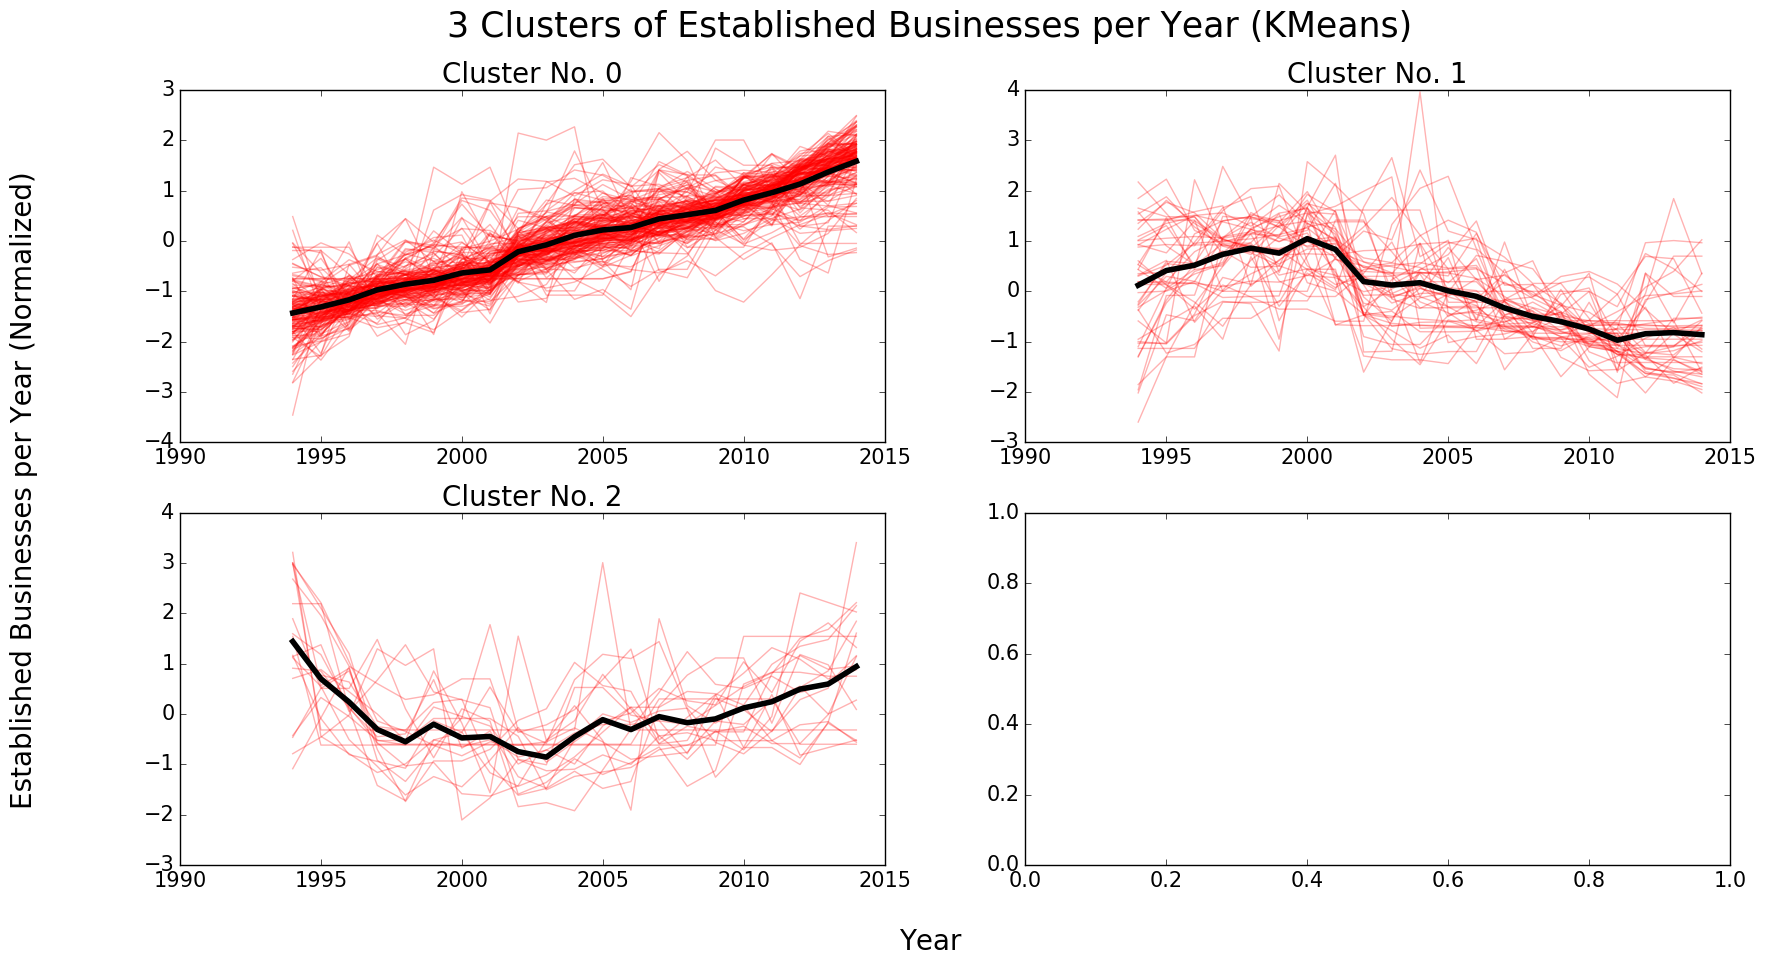

In [645]:
cluster_plot(crosstabbed, 3)

# Figure 1: Plot of KMeans clustering with 3 clusters for established businesses  in New York City by zipcode. One shows a steady upward trend, one shows a slight downard trend and the third shows a dip in the aughts, somewhat preceeding the recession. 

For 4 clusters the silhouette score is 0.484699311645


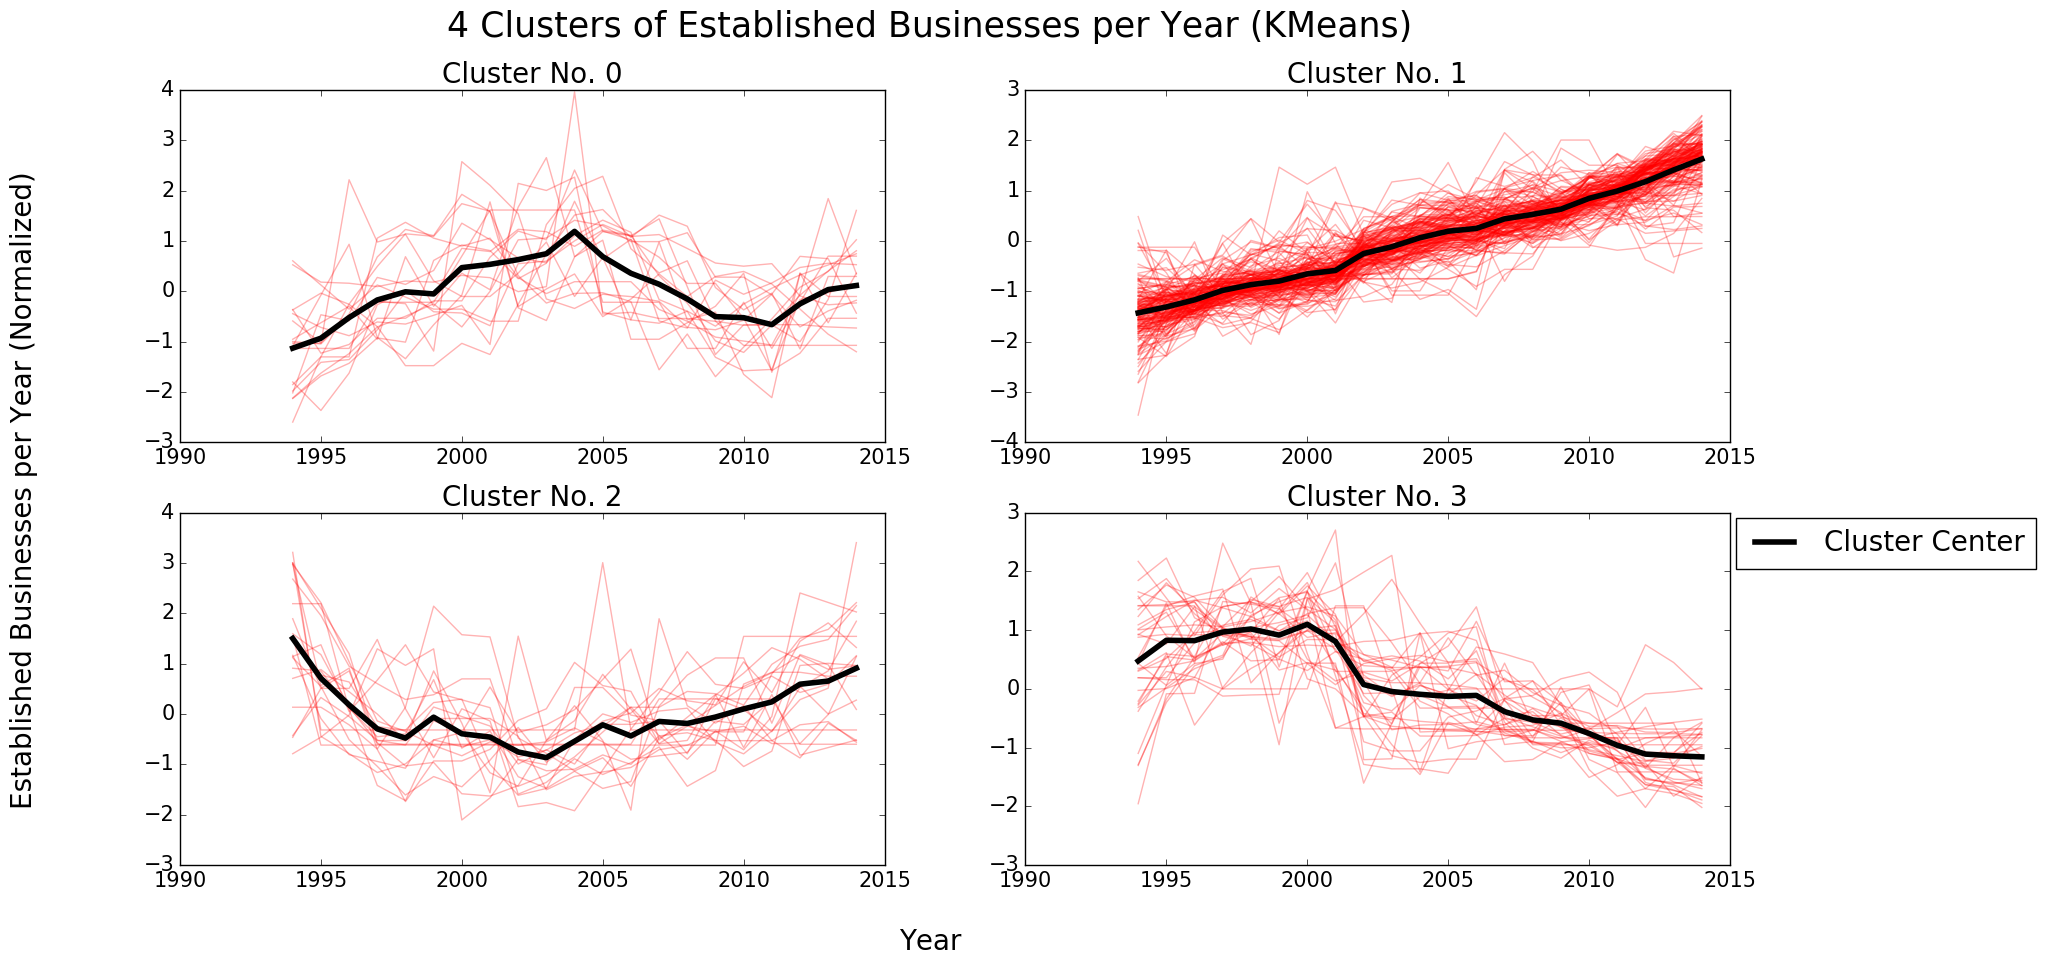

In [646]:
cluster_plot(crosstabbed, 4)

# Figure 2: Plot of KMeans clustering with 4 clusters for established businesses  in New York City by zipcode. One shows a steady upward trend, one shows a peak in the early aughts followed by a decline, one shows a slight downward trend and the fourth shows a dip in the aughts, somewhat preceeding the recession. 

For 5 clusters the silhouette score is 0.320186862566


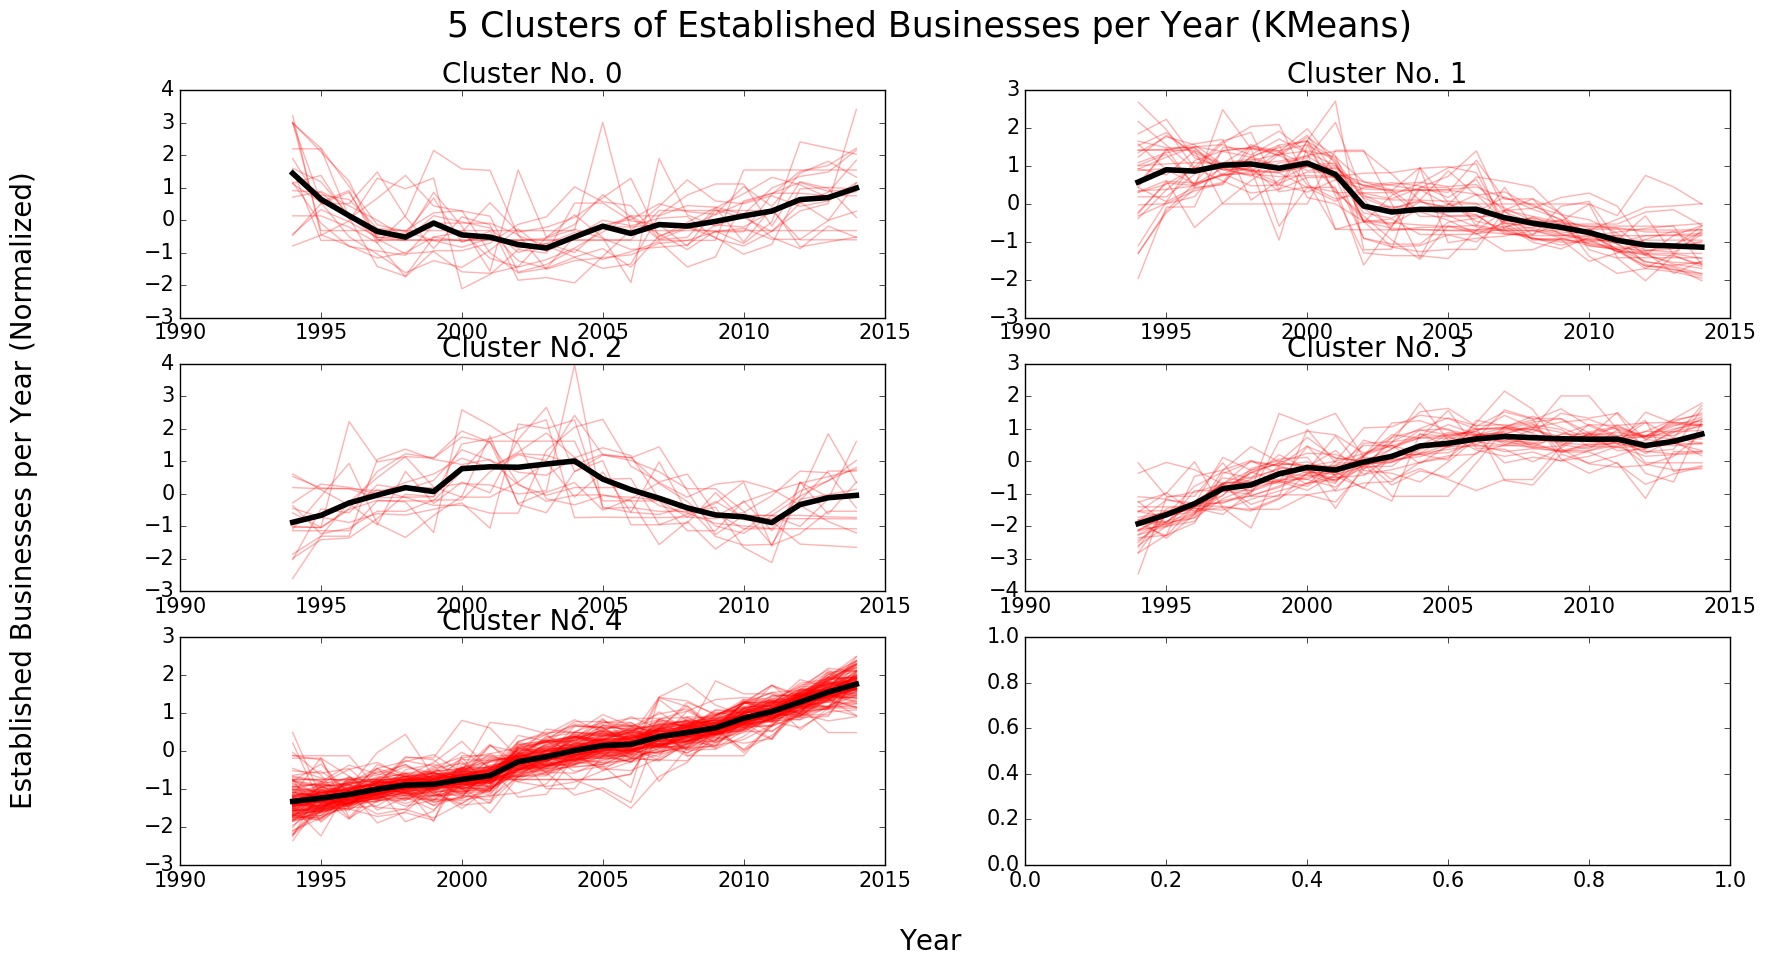

In [647]:
cluster_plot(crosstabbed, 5)

# Figure 3: Plot of KMeans clustering with 5 clusters for established businesses  in New York City. The generally upward cluster seems to have broken into two, with one showing very upward and the other showing slighty upward, while the other three show less of a trend. 

For 6 clusters the silhouette score is 0.306011103345


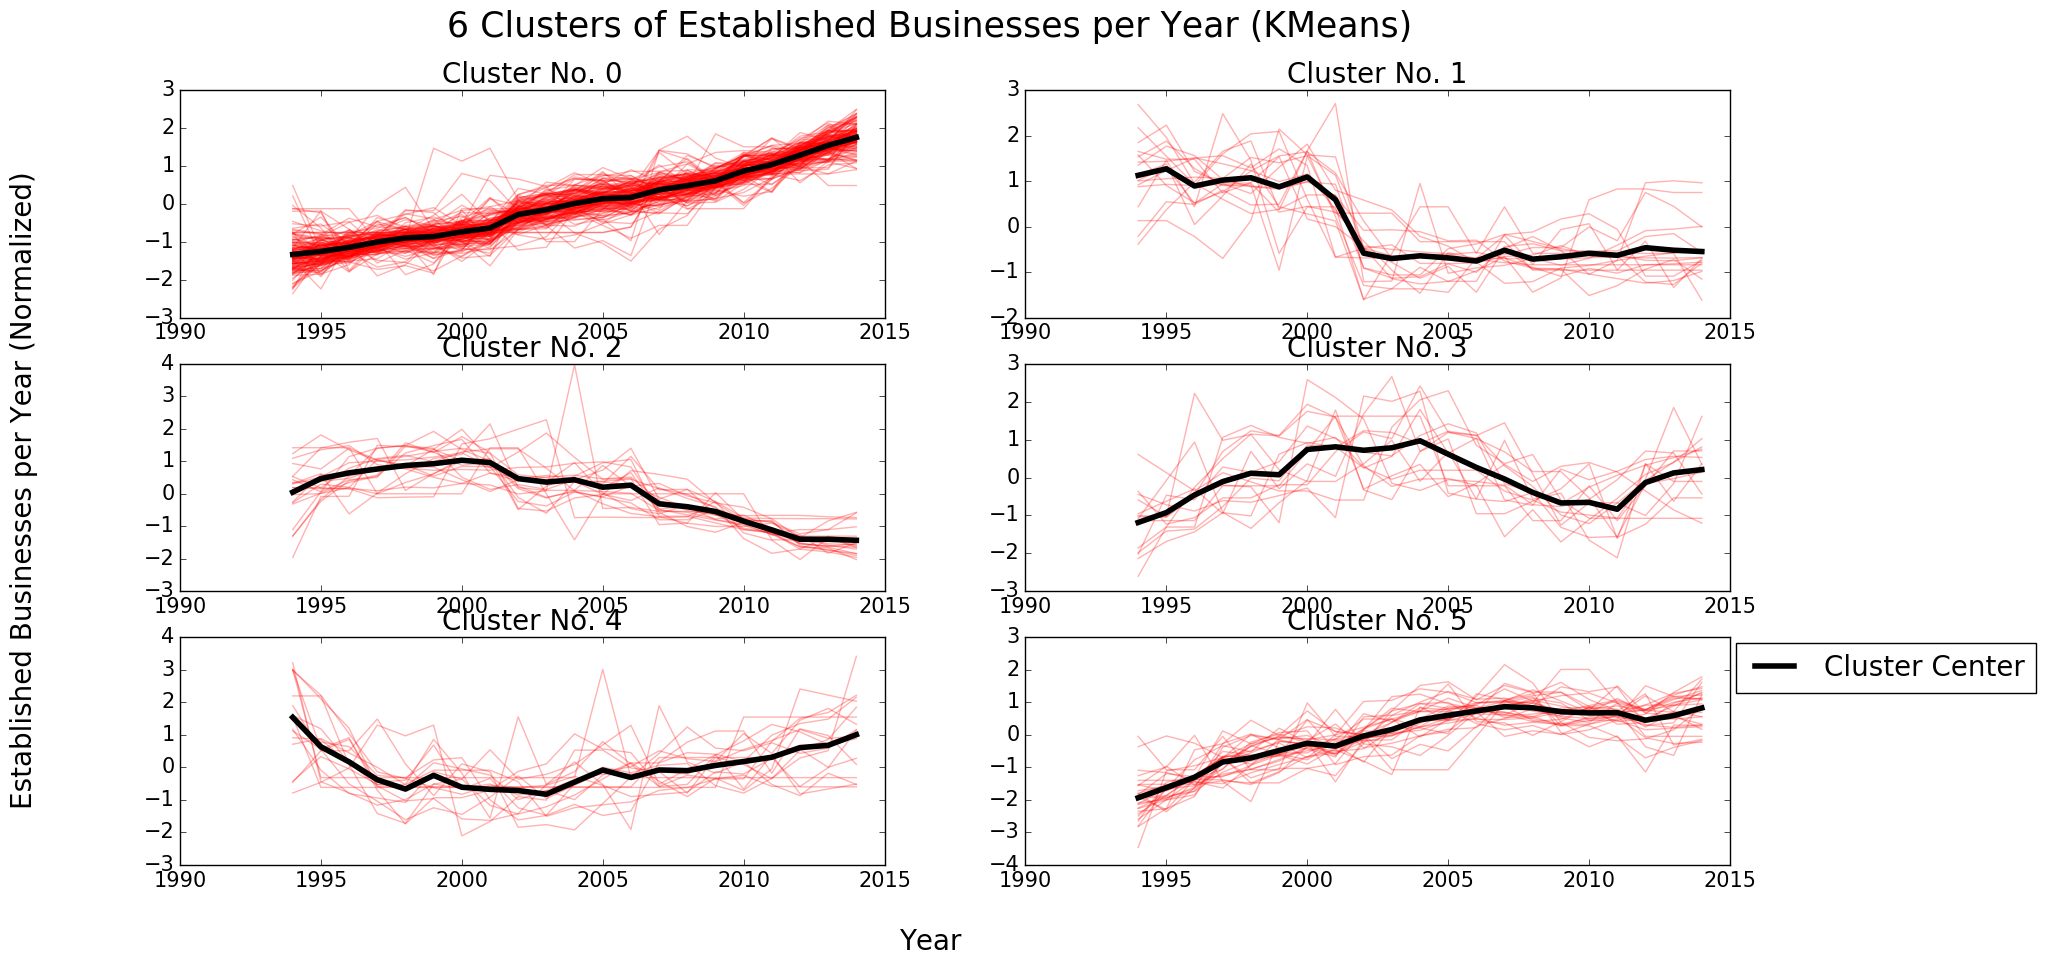

In [648]:
cluster_plot(crosstabbed, 6)

# Figure 4: Plot of KMeans clustering with 6 clusters for established businesses  in New York City. The generally upward cluster seems to have broken into two, with one showing very upward and the other showing slighty upward, there is a small cluster showing a precipitous decline after 2000 (perhaps 9/11 related) and the other three have minimal trends.

For 3 clusters the silhouette score is 0.4686309538


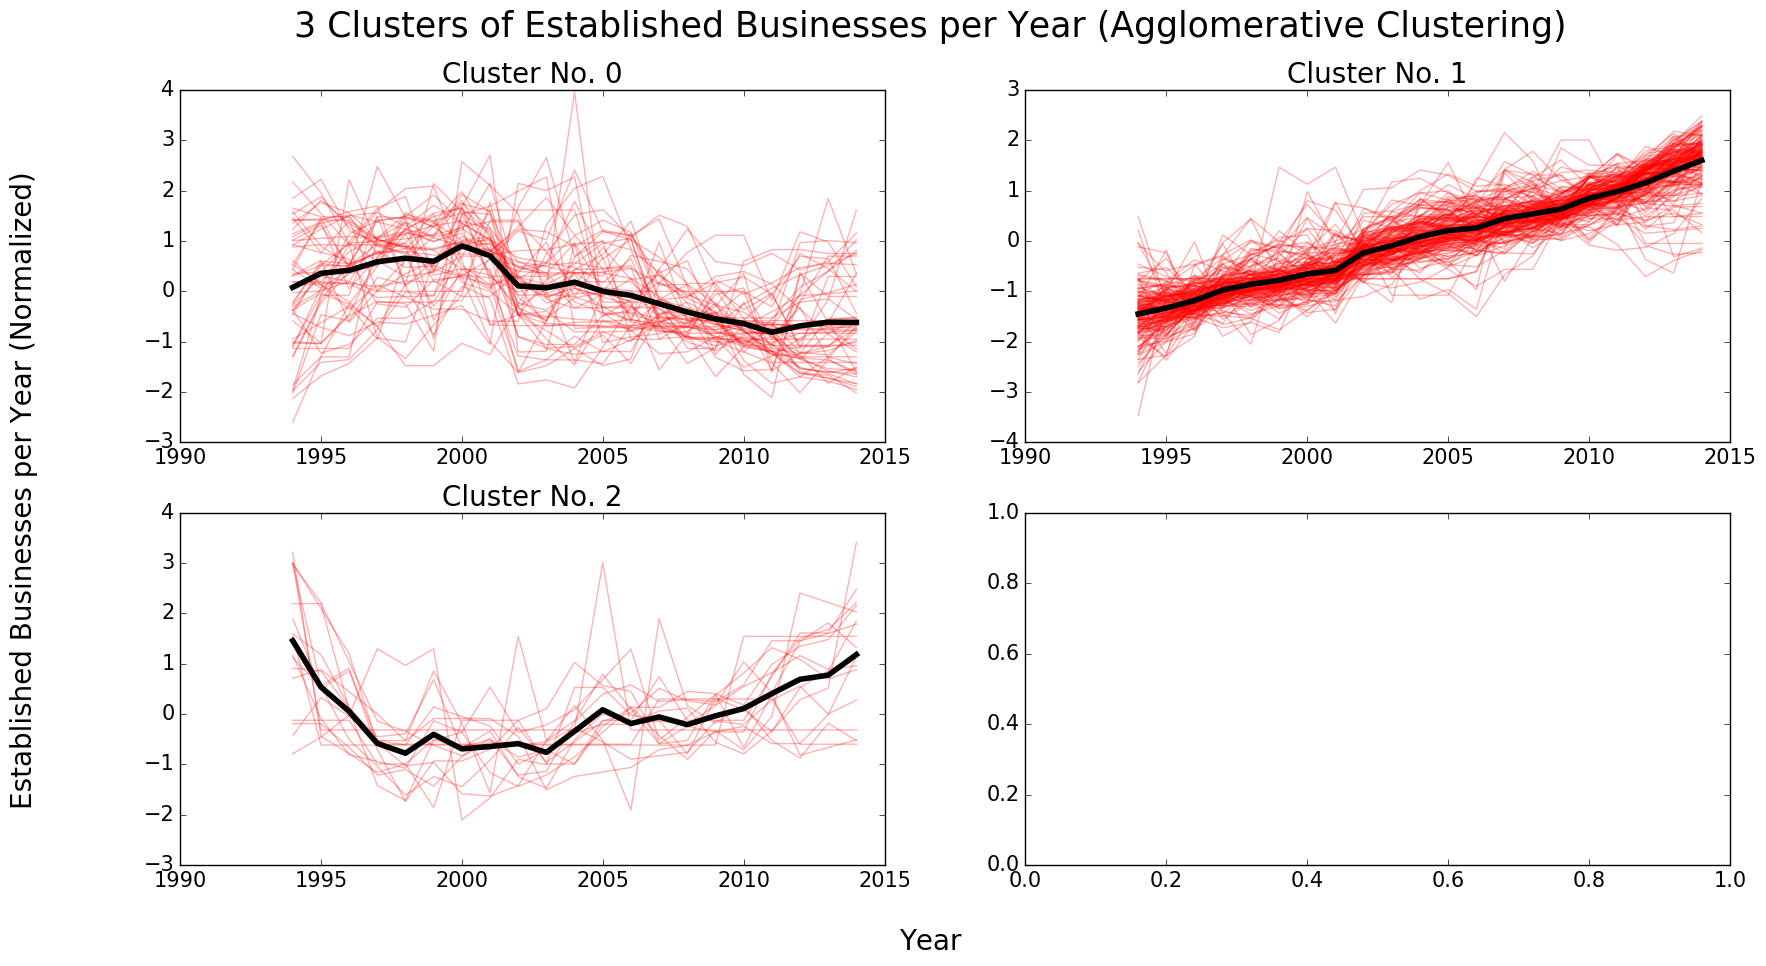

In [649]:
cluster_plot(crosstabbed, 3, 'AggClust')

# Figure 5: Plot of Agglomerative clustering with 3 clusters for established businesses  in New York City by zip code. One shows a steep upward trend, one shows a slightly downward trend and the third shows a dip in the aughts, similar to kmeans. 

For 4 clusters the silhouette score is 0.460781285294


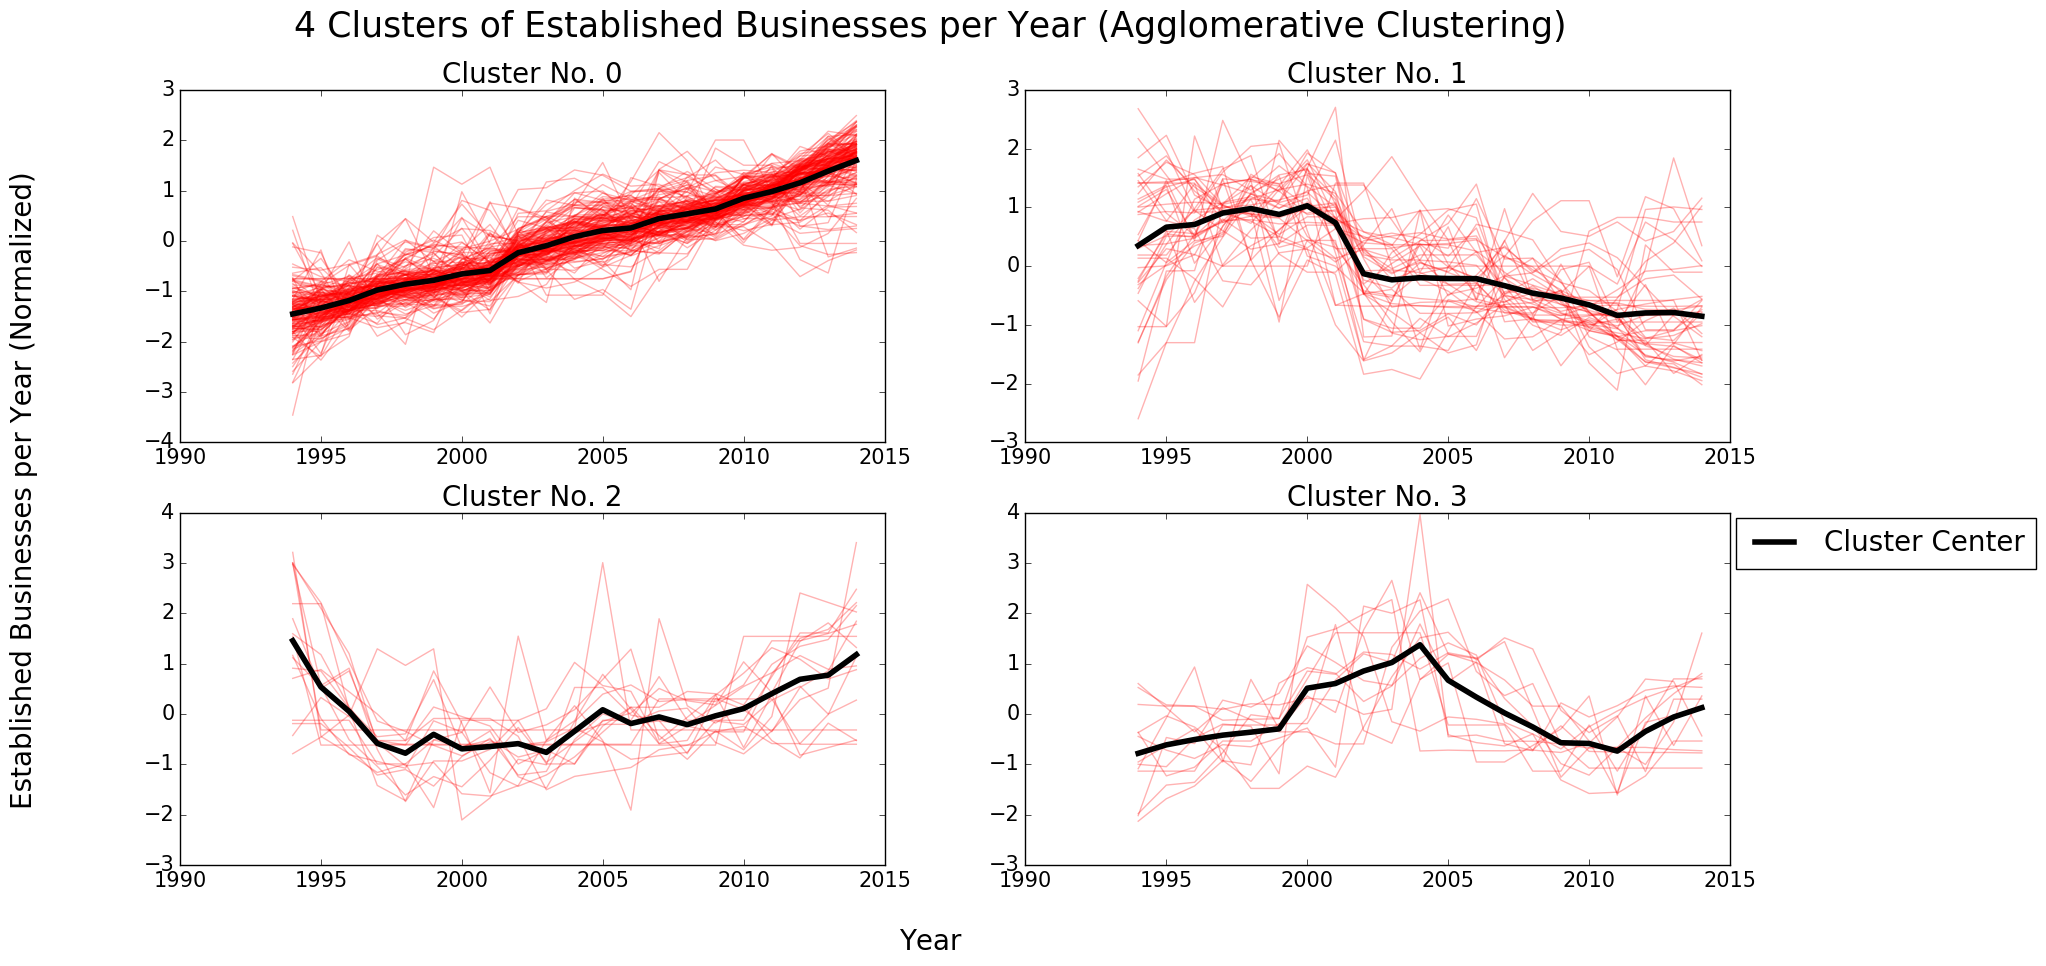

In [650]:
cluster_plot(crosstabbed, 4, 'AggClust')

# Figure 6: Plot of Agglomerative clustering with 4 clusters for established businesses  in New York City by zip code. Much like kmeans, one shows a steady upward trend, one shows a peak in the early aughts followed by a decline, one shows a slight downward trend and the fourth shows a dip in the aughts, somewhat preceeding the recession. 

For 5 clusters the silhouette score is 0.279341838564


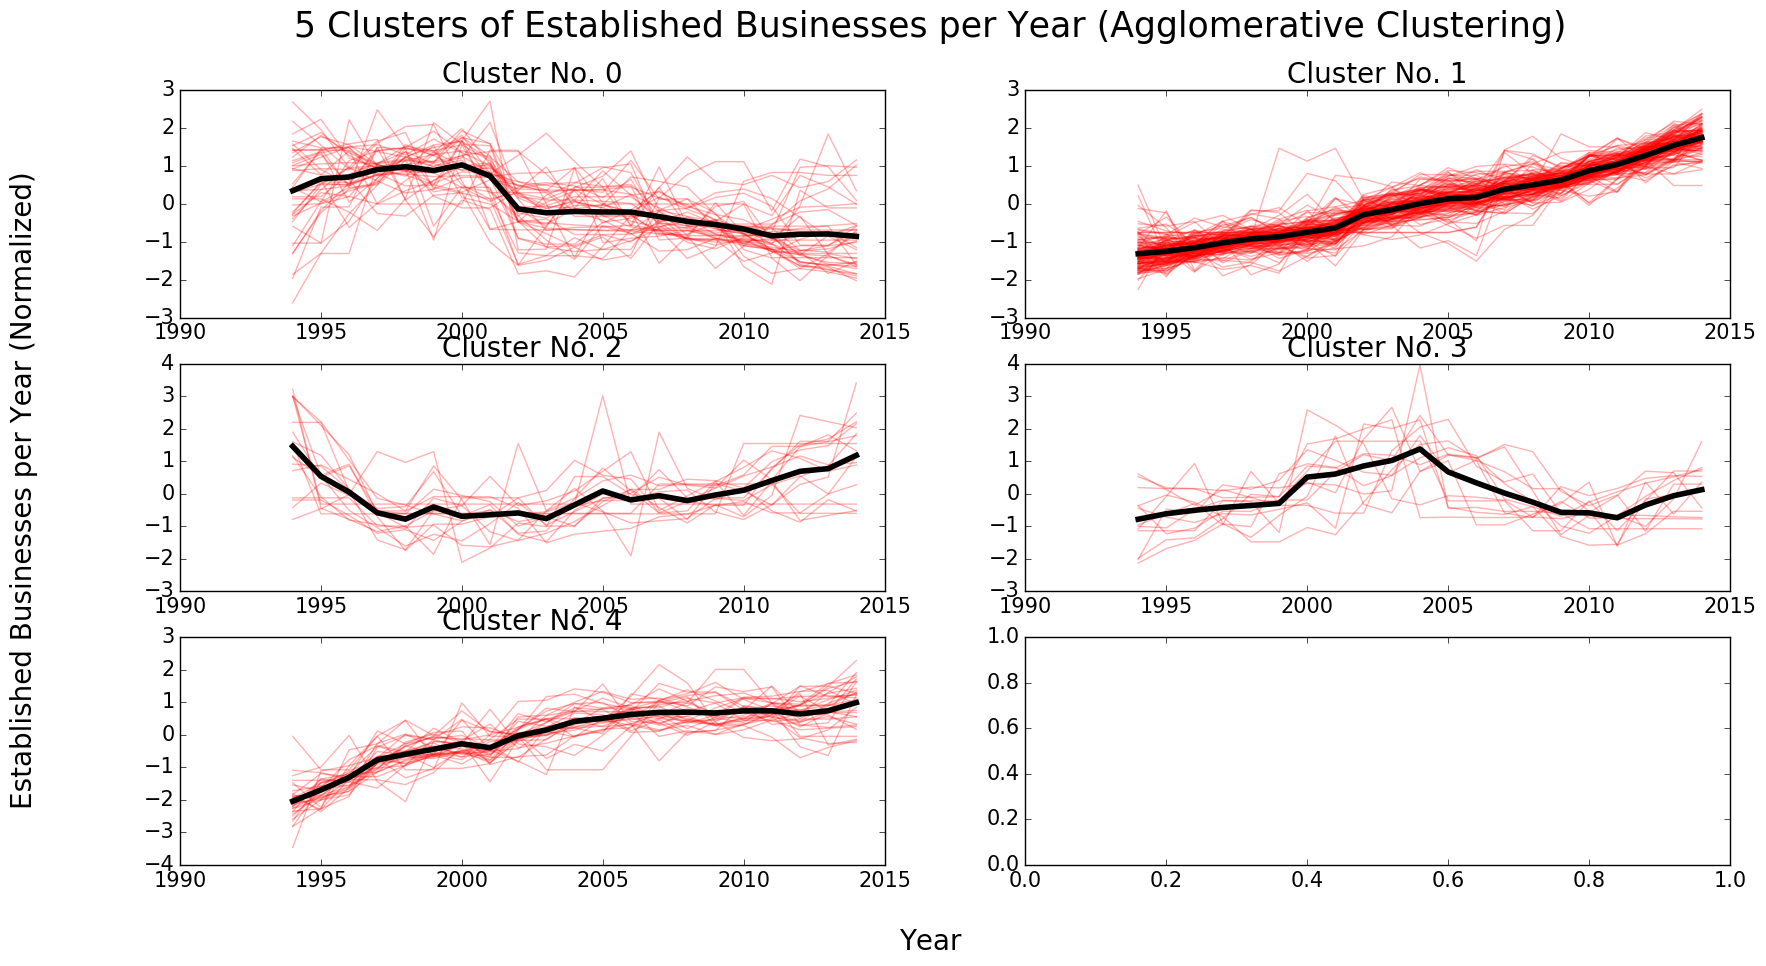

In [651]:
cluster_plot(crosstabbed, 5, 'AggClust')

# Figure 7: Plot of Agglomerative clustering with 5 clusters for established businesses  in New York City by zip code. We see two upward trends, one steeper than the other, one slight downward trend, one with a peak and one with a dip although the dip has flattened somewhat

For 6 clusters the silhouette score is 0.264488433396


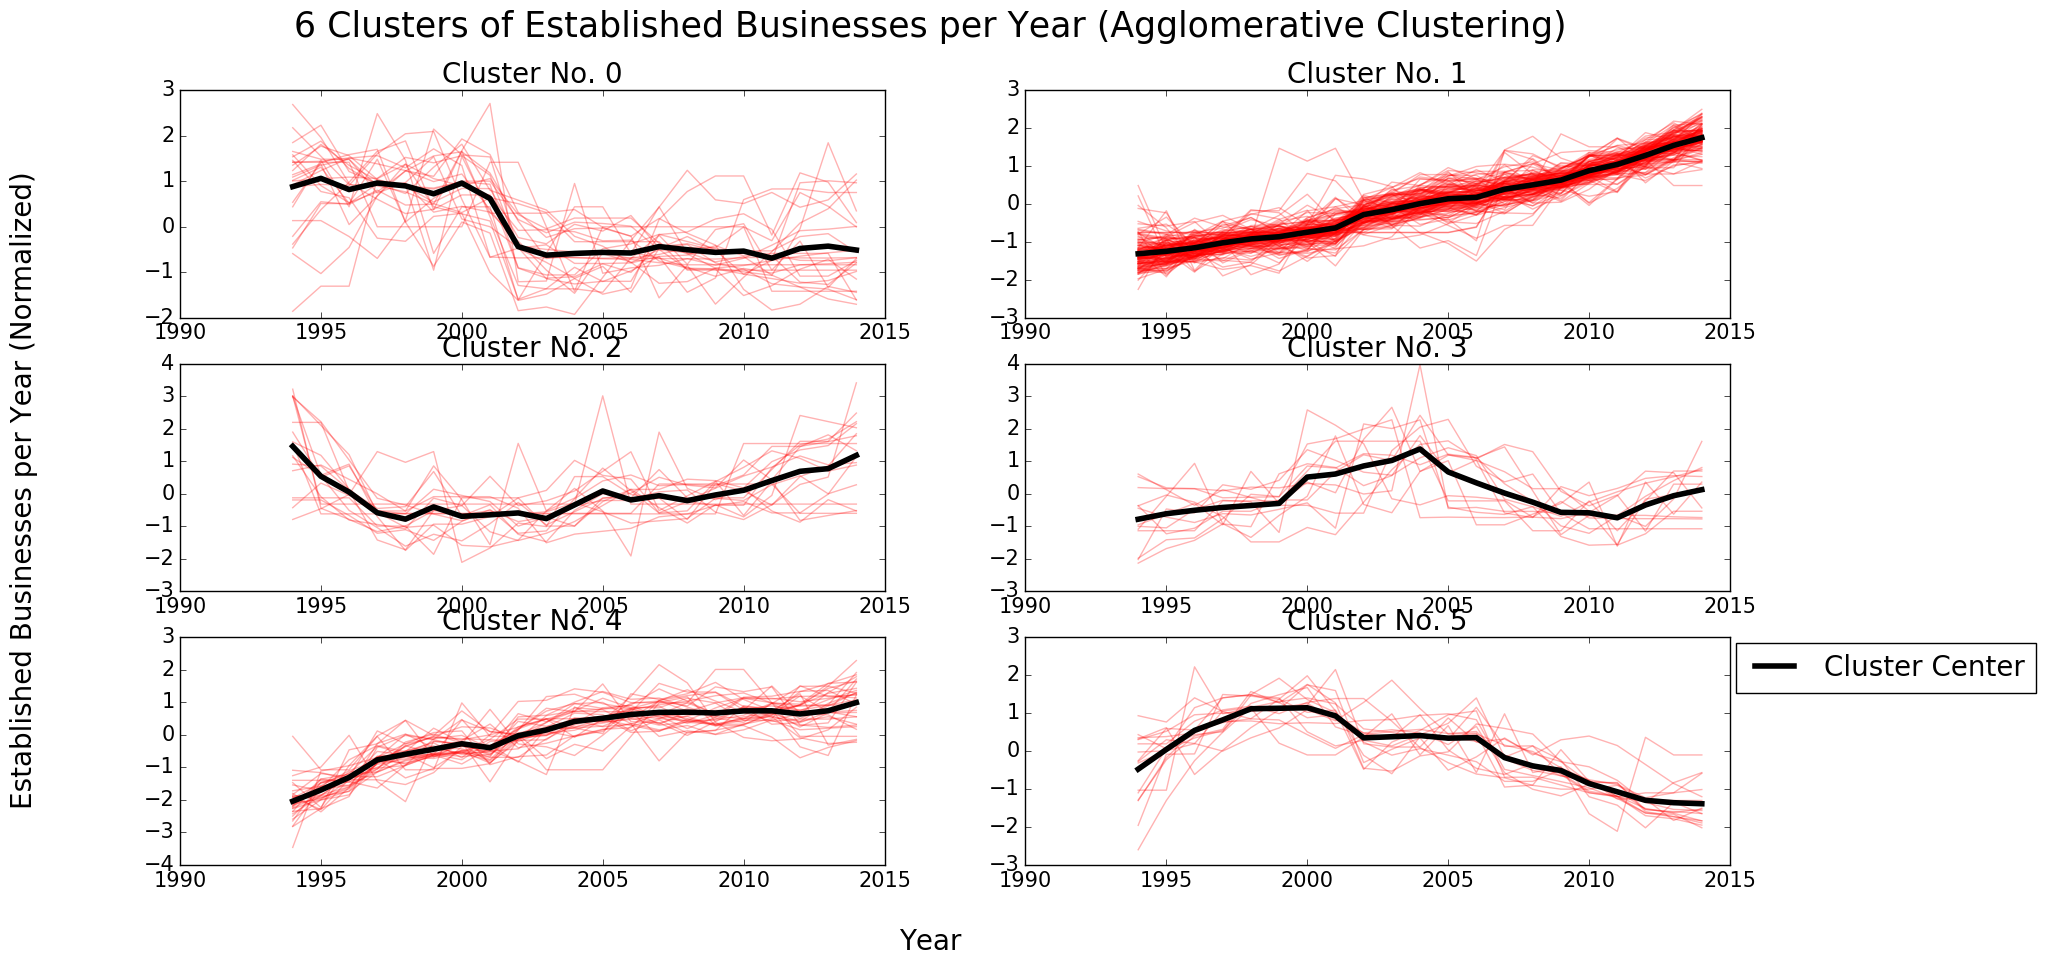

In [652]:
cluster_plot(crosstabbed, 6, 'AggClust')

# Figure 8: Plot of Agglomerative clustering with 6 clusters for established businesses  in New York City by zip code. Much like kmeans, this has found the cluster with the large drop off post 2001. 

# Plot 4 Clusters on a map of NYC. Although 3 clusters had a slightly higher silhouette score for both kmeans and agglomerative clustering, the 4 cluster method revealed the 2001 drop and I am interested in investigated whether that occurred near lower Manhattan and the World Trade Center

In [653]:
zc_shape_copy = zc_shape
zc_shape_copy.index = zc_shape.postalCode # change index for join

In [654]:
kmeans_labels = KMeans(4, random_state = 21).fit_predict(crosstabbed)
agglom_labels = AgglomerativeClustering(4).fit_predict(crosstabbed)

In [655]:
crosstabbed['kmeans_labels'] = kmeans_labels
crosstabbed['agglom_labels'] = agglom_labels
crosstabbed.index = [str(x) for x in crosstabbed.index] # convert crosstabbed index to str 

In [656]:
zc_shape_business = zc_shape.join(crosstabbed, how = 'outer') # combine business data with shapefile
zc_shape_business.kmeans_labels.dropna(inplace = True) # drop nas in each label column so that the colors will plot
zc_shape_business.agglom_labels.dropna(inplace = True)

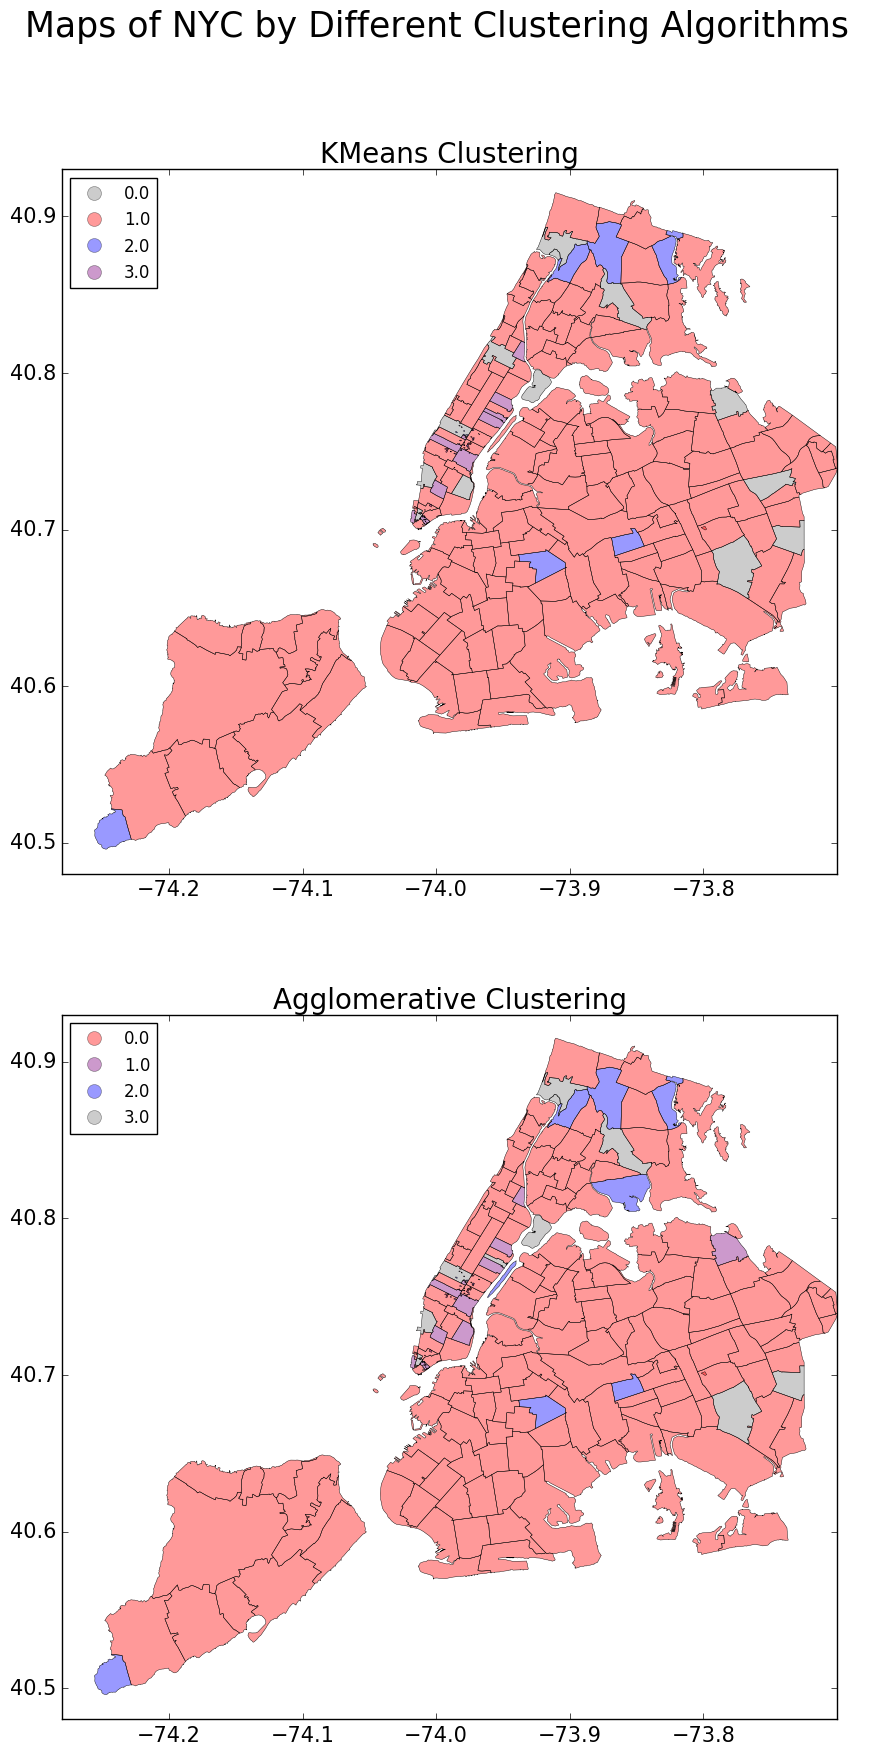

In [657]:
fig, ax = pl.subplots(2, 1, figsize = (10, 20))

pl.suptitle('Maps of NYC by Different Clustering Algorithms', fontsize = 25)
for i in range(len(ax)):
    ax[i].set_xlim(-74.28, -73.7)
    ax[i].set_ylim(40.48, 40.93)

# rep clusters with similar patterns with same colors 
kcmap = matplotlib.colors.ListedColormap(['grey','red', 'blue', 'purple']) 
acmap = matplotlib.colors.ListedColormap(['red', 'purple', 'blue','grey'])

zc_shape_business.plot(column = 'kmeans_labels', cmap = kcmap, categorical = True, ax = ax[0], 
                       linewidth = .3, legend = True, alpha = .4)
ax[0].set_title('KMeans Clustering', fontsize = 20)
zc_shape_business.plot(column = 'agglom_labels', cmap = acmap, categorical = True, ax = ax[1], 
                       linewidth = .3, legend = True, alpha = .4)
ax[1].set_title('Agglomerative Clustering', fontsize = 20)

pl.legend()

# Figure 9: Plots of KMeans and Agglomerative Clustering with 4 clusters. The algorithms had very similar results with only a few areas belonging to a different cluster. The clusters with the large drop after 2000 (3 for the kmeans and 1 for Agglomerative Clustering) did both contain the tract that formerly contained the World Trade Center although other most cluster-members were located in mid- and upper- Manhattan so 9/11 may not have been the driving force after all. The largest cluster for both algorithims representing steady upward trend in normalized established businesses contains most of the zipcodes throughout Brooklyn, Queens, the South Bronx and Staten Island especially as compared with Manhattan. Many of these zipcodes were economically depressed in the 80s or have been heavily devloped since so their growth may have been in part because they were playing catch up whereas Manhattan has been dense with businesses for decades.